# Exercise #9: Time Series Analysis with Categorical Data 


### Probabilistic Machine Learning

- **Lecturer**: Prof. Philipp Hennig
- **Term**: SoSe 2020
- **Due Date**: Monday, 29 June 2020


![](./figures/graphicalmodel.png)


On this exercise sheet, we are going to practice message passing in a graphical model using Gaussian processes, the Laplace bridge and categorical data.
Other than on many of the previous sheets, we are using an artificial data set today.
The structure is the following:

1. **Time series data:** The usual loading and processing of data.
2. **Laplace bridge:** Implementation of the Laplace bridge and basic checkups.
3. **Combining GPs with a graphical model:** How do we use GPs in a GM.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import solve, cholesky

## 1. Time series data


On this sheet we are working with time series data. 
You may think of it as the results of a political election.
There are $M=6$ parties and the election has taken place every year for the past $N=250$ years (we are at year 250 now and the first year was year 0).
Each of the 6 parties has received a number of votes out of a total of 55 votes per election.

Below you find a snippet that loads the `timeseries.csv` data set into a `pd.DataFrame`.


In [2]:
data = pd.read_csv("./data/timeseries.csv", index_col=0)

In [3]:
# extract some useful quantities
ntimepts = data.values.shape[0]
ncategs = data.values.shape[1]

**Task:**
Plot the cumulative results of each party over time, for instance like the following:

![](./figures/topic_plot.png)

This kind of plot will be interesting below as it is a simple way to visualise time-evolution of discrete probability distributions. *Hint:* `pd.DataFrame` objects have a built-in method `.plot.area()`. 

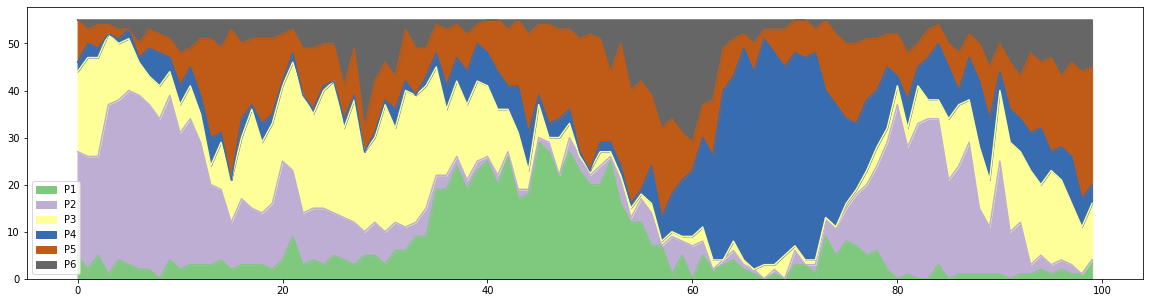

In [4]:
######################
#
# Your code goes here
data.plot.area(colormap='Accent', figsize=(20,5))
#
######################

Now that we have a first idea of the data set, we can start working.


**Task:** Split the data into a training set and a test set.

In [5]:
######################
#
# Your code goes here 
data = data.to_numpy()
train_data, test_data = data[:80], data[80:]
######################

## 2. Laplace Bridge

The Laplace bridge is a way to map a Dirichlet random variable $\pi \sim \text{Dir}(\alpha)$ to a Gaussian random variable $y \sim \mathcal{N}(\mu, \Sigma)$ through
\begin{align*}
\mu_m &= \log \alpha_m - \frac{1}{M}\sum_{\ell=1}^M \log \alpha_\ell. \\
\Sigma_{mm} &=  \frac{1}{\alpha_m} \left(1 - \frac{2}{M} \right)
    + \frac{1}{M^2}\sum_{\ell=1}^M \frac{1}{\alpha_\ell}.
\end{align*}
Its inverse is given by the map 
\begin{align}
 \alpha_m = \frac{1}{\Sigma_{mm}} \left( 1 - \frac{2}{M} + \frac{e^{\mu_m}}{M^2} \sum_{\ell=1}^M e^{-\mu_\ell}\right).
\end{align}
Derivation of both of these formulas was part of the theoretical exercise.


**Task:** Implement a function that maps a Dirichlet concentration hyperparameter $\alpha \in \mathbb{R}_+^M$ to a Gaussian random variable $\mu \in \mathbb{R}^M$, $\Sigma \in \mathbb{R}^{M \times M}$ for number of categories $M$. Implement another function that does the reverse.

In [6]:
def dir2gauss(alpha):
    ######################
    #
    # Your code goes here
    M = np.size(alpha)
    mu = np.log(alpha) - np.mean(np.log(alpha))
    diag = (1 - 2 / M) * 1 /alpha + np.mean(1/alpha)/M
    var = np.diag(diag)
    return mu, var
    ######################

def gauss2dir(mean, var):
    ######################
    #
    # Your code goes here
    M = np.size(mean)
    diag = np.diag(var)
    alpha = (1 / diag) * (1 - 2 /M + ((np.exp(mean)/ M**2) * np.sum(np.exp(-mean))))
    return alpha
    ######################
    


The Laplace bridge (LB) is an injective function from the space of Dirichlet concentration parameters $\alpha$ to the space of Gaussians, parameterised by mean $\mu$ and covariance $\Sigma$.

To validate our implementation, below there is a test that checks that wherever the inverse of the LB is well-defined, we have implemented it correctly. The function `test_dir2dir` checks that the map $\alpha \mapsto (\mu, \Sigma) \mapsto \alpha$ is the identity.

In [7]:
def test_dir2dir(ncategs_=5):
    """
    Dirichlet to Gaussian to Dirichlet 
    should be the identity.
    """
    alpha_ = np.random.rand(ncategs_)
    assert np.linalg.norm(gauss2dir(*dir2gauss(alpha_))- alpha_) < 1e-12

In [8]:
# Execution of tests

testnums = np.random.randint(2, 50, 5)
for ncats in testnums:
    test_dir2dir(ncats)

In the theoretical exercise you have shown that the Laplace bridge relies on a change of coordinates: Dirichlet realisations $\pi_r$ ("r" for "realisation") are written as the softmax of Gaussian realisations $\sigma(y_r)$, where $y_r$ is a realisation of a Gaussian  $y$.
Later on we will have to decide whether we construct a point estimator in $y$ and map this to a Dirichlet through the softmax or whether we map the distribution $y$ to a Dirichlet through the inverse LB and construct a point estimator then.

**Task:** Implement the softmax and compare those two approaches. Are they the same? Which one is the preferrable option and why?

<font color="blue">No, they are not the same. We would prefer to use the Laplace bridge because it gives us an additional degree of freedom, which changes the shape of the distribution.</font>

In [9]:
def softmax(arr):
    ######################
    #
    # Your code goes here
    arr = arr - np.max(arr)
    num = np.exp(arr)
    return num/np.sum(num)
    ######################

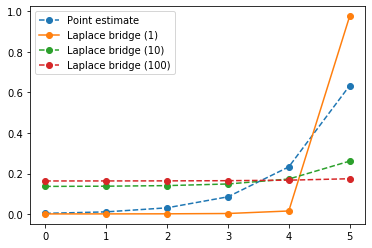

In [10]:
######################

dir_pe = softmax(np.arange(ncategs))
dir_lb_1 = softmax(gauss2dir(np.arange(ncategs), np.diag(1 * np.ones(ncategs))))
dir_lb_10 = softmax(gauss2dir(np.arange(ncategs), np.diag(10 * np.ones(ncategs))))
dir_lb_100 = softmax(gauss2dir(np.arange(ncategs), np.diag(100 * np.ones(ncategs))))

plt.plot(dir_pe, '--o')
plt.plot(dir_lb_1, '-o')
plt.plot(dir_lb_10, '--o')
plt.plot(dir_lb_100, '--o')
plt.legend(["Point estimate", "Laplace bridge (1)", "Laplace bridge (10)", "Laplace bridge (100)"])
plt.show()

######################

The Laplace bridge is in place and working now. We are able to pass messages between Dirichlets and Gaussians and through conjugacy, between categoricals, Dirichlets and Gaussians.

## 3. Combining GPs with a graphical model


Let $f = (f_1, ..., f_M)$, $f_m \sim \text{GP}(0, k)$ be $M$ independent Gaussian processes, each with covariance kernel $k=k(t, t')$.
Denote the time-points of the data by $t_1, ..., t_N$.

Consider the following graphical model. Let $y \in \mathbb{R}^M$ be a Gaussian random variable that stems from evaluating each of the Gaussian processes $f_1, ..., f_M$ at time $t \in \{t_1, ..., t_N\}$, let $\pi \in \mathbb{R}_+^M$ be a Dirichlet r.v. and $c \in \mathbb{N}^M$ a categorical random variable.

![](./figures/graphicalmodel.png)
The orange rectangle denotes the softmax transformation and the associated Laplace bridge. The blue rectangle denotes the Dirichlet-categorical conjugacy. The random variable $c$ is observed at each time $t_1, ..., t_N$ (and as an observed r.v., marked with double circles).


Assume that the $M$ GPs $f=(f_1, ..., f_M)$ are independent and each has the same covariance kernel $k$.
Those GPs shall encode the time-correlation between observation (as features). Eventually, we will do GP regression in the $y$ space and to this end, we need two ingredients: a prior and a likelihood.


### Prior distribution

As always, we choose a prior by choosing a covariance kernel $k$. Below you find an implementation of a square exponential kernel. The hyperparameters were chosen manually: $\sigma^2$ is such that the inverse Laplace bridge gives a natural Dirichlet prior $\alpha = (1, ..., 1) / M$ and the length-scale is a guess from looking at the plotted data.

In [11]:
# inverse of natural dirichlet parameter.
ssq = dir2gauss(np.ones(ncategs) / ncategs)[1].mean()

def kernelfct(t, s):
    """
    Square exponential kernel
    for a SINGLE Gaussian process.
    """
    return ssq*np.exp(-np.abs(t-s)**2/20)

def kmat(tset, sset):
    """
    Kernel matrix out of a kernel function
    for a SINGLE Gaussian process.
    """
    return np.array([[kernelfct(t, s) for s in sset] for t in tset])

### Constructing a Likelihood

Let us start with trying something is not going to work.
The easiest way to train the GP would be to take the categorical data, normalise them out into something *like* a Dirichlet (which is not a real Dirichlet because the concentration can have zeros!), transform them through the inverse softmax into GP data $d_{11}, ..., d_{N1}, d_{12}, ..., d_{NM}$. Then we can condition the GP on this data and voila!
*This approach does not work*: (i) For the same reasons that the normalised data is only *like* a Dirichlet and not a true Dirichlet, the inverse softmax will fail because it involves logarithms (and the logarithm of 0 is $-\infty$); (ii) the inverse softmax is not unique.

As a natural remedy, we use a Gaussian process prior and *for each* data point $t_n$, we evaluate the prior Gaussian distribution $f(t_n) \sim \mathcal{N}(0, I_M \otimes k(t_n, t_n))$ and transform them into a Dirichlet through the inverse Laplace bridge

$$
\text{Dir}(\alpha_n) = p(\pi_n | f(t_n)) = \text{LB}^{-1}(p(f(t_n)), \quad \pi_n =: \pi(t_n).
$$

This is now a prior Dirichlet distribution $\pi_n \sim \text{Dir}(\alpha_n)$ at each $t_n$. Using the observations $c_n$ at $t_n$, we update this Dirichlet through conjugacy,

$$
p(\pi_n | c_n) = \text{Dir}(\alpha_n + c_n) = \frac{p(c_n | \pi_n) p(\pi_n)}{p(c_n)} = \frac{p(c_n |\pi_n)}{p(c_n)}\text{Dir}(\alpha_n) 
$$

and obtain again a Dirichlet distribution. This is the posterior now (in the Dirichlet language) but still agnostic of time-dependency.
Notice however, that the Bayes' update with likelihood $\frac{p(c_n | f(t_n), \pi_n)}{p(c_n)}$ can be computed in the space of Gaussians instead of the space of Dirichlets using $\pi_n \approx f(t_n)$ as encoded in the Laplace bridge:

$$
p(f(t_n) | c_n) = \frac{p(c_n | f(t_n))}{p(c_n)} p(f(t_n)) = \frac{\text{LB}(\text{Dir}(\alpha_n + c_n))}{\text{LB}(\text{Dir}(\alpha_n))}p(f(t_n))
$$

which is a likelihood that we can use for GP regression. This is because both $\text{LB}(\text{Dir}(\alpha_n + c_n))$ and $\text{LB}(\text{Dir}(\alpha_n))$ are Gaussian distribution and in the EXAMple question you have derived a formula for the quotient of Gaussian distributions in terms of a Gaussian parameterisation. Denote this distribution by $\mathcal{N}(m_n^c, S_n^c)$ where the superscript $c$ emphasises that those arrays are informed about the categorical data.
We conclude the following rule:

$$
p(f(t_n) | c_n) = \mathcal{N} (m_n^c, S_n^c) \mathcal{N}(0, I_M \otimes k(t_n, t_n))
$$

for $m_n^c \in \mathbb{R}^M$, $S_n^c \in \mathbb{R}^{M \times M}$.

**Task:** Implement a function that computes the quotient of two Gaussian distributions and returns another Gaussian distribution.

In [12]:
def gaussdiv(m1, s1, m2, s2):
    ######################
    #
#     from scipy.linalg import cho_factor, cho_solve
#     ch_s1 = cho_factor(s1)
#     ch_s2 = cho_factor(s2)
#     inv_s1 = np.linalg.inv(s1)
#     inv_s2 = np.linalg.inv(s2)
#     s = np.linalg.inv(inv_s1 - inv_s2)
#     m = s @ (m1 @ inv_s1 - m2 @ inv_s2)
#     return m, s

#     l1 = cholesky(s1) 
#     l2 = cholesky(s2)
#     p1 = cho_solve((l1, True), np.eye(s1.shape[0]))
#     p2 = cho_solve((l2, True), np.eye(s2.shape[0]))

    p1 = solve(s1, np.eye(s1.shape[0]))
    p2 = solve(s2, np.eye(s2.shape[0]))
    cov = solve(p1-p2, np.eye(s1.shape[0]))
    m = cov @ (p1 @ m1 - p2 @ m2)
    return m, cov


    ######################
    

**Bonus task:** Implement a function that computes the product of two Gaussian distributions and returns another Gaussian distribution. Use this function to test whether the quotient-function is implemented correctly.

In [13]:
def gaussprod(m1, s1, m2, s2):    
    ######################
    #
    # Your code goes here 
#     l1, l2 = cholesky(s1), cholesky(s2)
#     p1 = cho_solve((l1, True), np.eye(s1.shape[0]))
#     p2 = cho_solve((l2, True), np.eye(s2.shape[0]))
    p1 = solve(s1, np.eye(s1.shape[0]))
    p2 = solve(s2, np.eye(s2.shape[0]))
    cov = solve(p1+p2, np.eye(s1.shape[0]))
    m = cov @ (p1 @ m1 + p2 @ m2)
    return m, cov
    ######################
    

**Task:** Write a function that computes the values $m_n^c, S_n^c$ for each $t_n$ in the training set and each measurement $c_n$ in the data by passing the messages 

$$
\mathcal{N}(0, I_M \otimes k(t_n, t_n)) \rightarrow \text{Dir}(\alpha_n) \rightarrow \text{Dir}(\alpha_n + c_n)\rightarrow \text{LB}( \text{Dir}(\alpha_n + c_n))
$$

and by using the formula 

$$
\mathcal{N}(m_n^c, S_n^c) = \frac{\text{LB}(\text{Dir}(\alpha_n + c_n))}{\mathcal{N}(0, I_M \otimes k(t_n, t_n))}
$$

that you have implemented earlier.

In [14]:
######################
def likelihood(c_n, t_n):
    I_M = np.eye(ncategs)
    var_n = I_M * kernelfct(t_n, t_n)
#     alpha_n = np.ones(ncategs)/ ncategs
    
    alpha_n = gauss2dir(np.zeros(ncategs), var_n)
    mean, var = dir2gauss(alpha_n + c_n)
    mnc, snc = gaussdiv(mean, var, np.zeros(ncategs), var_n)
    
    return mnc, snc
    
# 
#
######################

**Task:** Compute all of the $m_n^c$, $S_n^c$ for each $t_n$ and $c_n$.

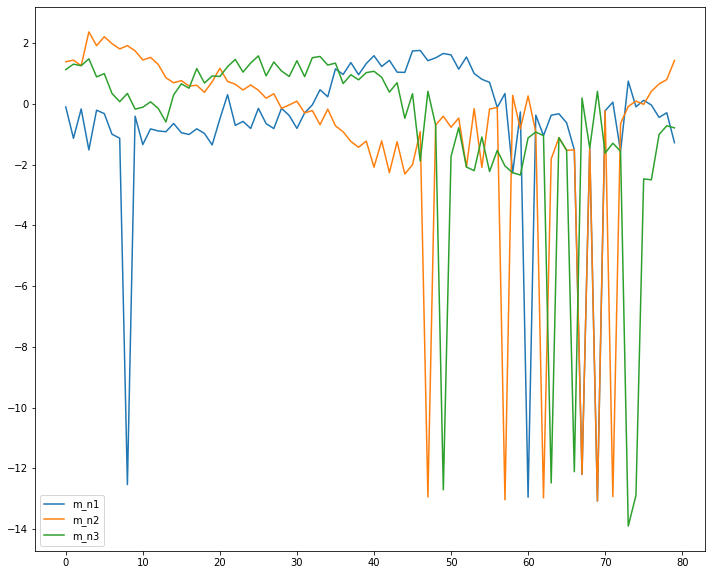

In [15]:
######################
mn = []
Sn = []
for t in range(len(train_data)):
    #     m, S = compute_mean_var(np.sum(train_data[:t], axis = 0), t)
    m, S = likelihood(train_data[t], t)
    mn.append(m)
    Sn.append(S)
mn = np.array(mn)
Sn = np.array(Sn)

plt.figure(figsize=(12,10))
plt.plot(np.arange(train_data.shape[0]), mn[:,0], label='m_n1')
plt.plot(np.arange(train_data.shape[0]), mn[:,1], label='m_n2')
plt.plot(np.arange(train_data.shape[0]), mn[:,2], label='m_n3')
plt.legend()

plt.show()
######################


Now we are ready to train the GP.

**Task:** Train each Gaussian process $f_1, ..., f_M$ on data with likelihood $m_n^c, S_n^c$. Write a function that evalutes the posterior mean at arbitrary point $t$ (which could be contained in either, training or test set). 
*Hint:* In order to be able to train once and evaluate many times, it might be advantageous to compute the natural parameters of the posterior distribution $p(f | c)$, say $\tilde P$ and $\tilde M$ such that the function that evaluates the distribution $f(t)$ at new time point $t$ returns mean and covariance

$$
\mu(t) = k_M(t, \mathcal{T}) \,\tilde M, \quad \Sigma(t, s) = k_M(t, s) - k_M(t, \mathcal{T})\, \tilde P \,k_M(\mathcal{T}, s) 
$$

for training set $\mathcal{T} = \{t_1, ..., t_N\}$ and covariance $k_M(t, s) = I_M \otimes k(t, s)$.


In [16]:
######################
#
# def calc_P_M(mn, Sn):
#     post_mean = np.mean(mn, axis = 0)
#     post_var = np.mean(Sn, axis = 0)
#     inv_mat = solve(cholesky(post_var), np.eye(post_var.shape[0])) 
#     P_tilde = 0.5 * inv_mat
#     M_tilde = - inv_mat @ post_mean
#     return P_tilde, M_tilde

# def mean_t(t, ntimepts, M_tilde):
#     timesteps = np.arange(ntimepts)
#     ker_t = kmat(timesteps, np.array([t]))
#     print(ker_t.shape)
#     return ker_t @ M_tilde
    
# def covar(t, s, ntimepts, P_tilde):
#     timesteps = np.arange(ntimepts)
#     ker_ts = kernelfct(t, s)
#     ker_s = kmat(timesteps, np.array([s]))
#     ker_t = kmat(np.array([t]), timesteps)
#     covar = ker_ts - ker_t @ P_tilde @ ker_t
#     return covar



def train(m1, s1, m2, s2):
    inv_s1 = solve(s1, np.eye(s1.shape[0]))
    inv_s2 = solve(s2, np.eye(s2.shape[0]))
    P_tilde = 0.5 * (inv_s1 + inv_s2)
    M_tilde = - (inv_s1 @ m1 + inv_s2 @ m2)
    
    return P_tilde, M_tilde


def evaluate(P_tilde, M_tilde, t):
    timesteps = np.arange(train_data.shape[0])
    mu_t = kmat(t, timesteps) @ M_tilde
    sigma_ts = kmat(t, t) - kmat(t, timesteps) @ P_tilde @ kmat(timesteps, t)
    
    return mu_t, sigma_ts
#
######################

In [17]:
######################
#
timesteps = np.arange(train_data.shape[0])
m2 = np.zeros(train_data.shape[0])
s2 = kmat(timesteps, timesteps)

nat_params = []

for i in range(ncategs):
    P_tilde, M_tilde = train(mn[:,i], np.diag(Sn[:,i,i]), m2, s2)
    nat_params.append([P_tilde, M_tilde])
######################

We use the posterior mean as a point estimate but feel free to use whatever you like instead.

**Task:** Write a function that extracts a point estimate from the posterior distribution and turns it into a point estimate for the posterior dirichlet distribution. *Hint:* Softmax.


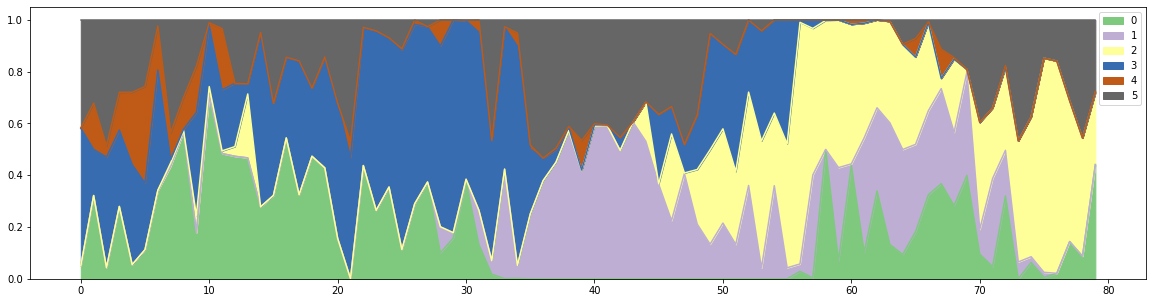

In [18]:
######################

Ms = np.array([
    M
    for P, M in nat_params
])

softmax_M = np.zeros_like(Ms)

for i in range(Ms.shape[1]):
    softmax_M[:, i] = softmax(Ms[:, i])
    
pd.DataFrame(softmax_M.T).plot.area(colormap='Accent', figsize=(20,5))

**Task:** Compute this point estimate for the training set and compare it to the actual training inputs, by e.g. visualising the results.

They should be recovered well.

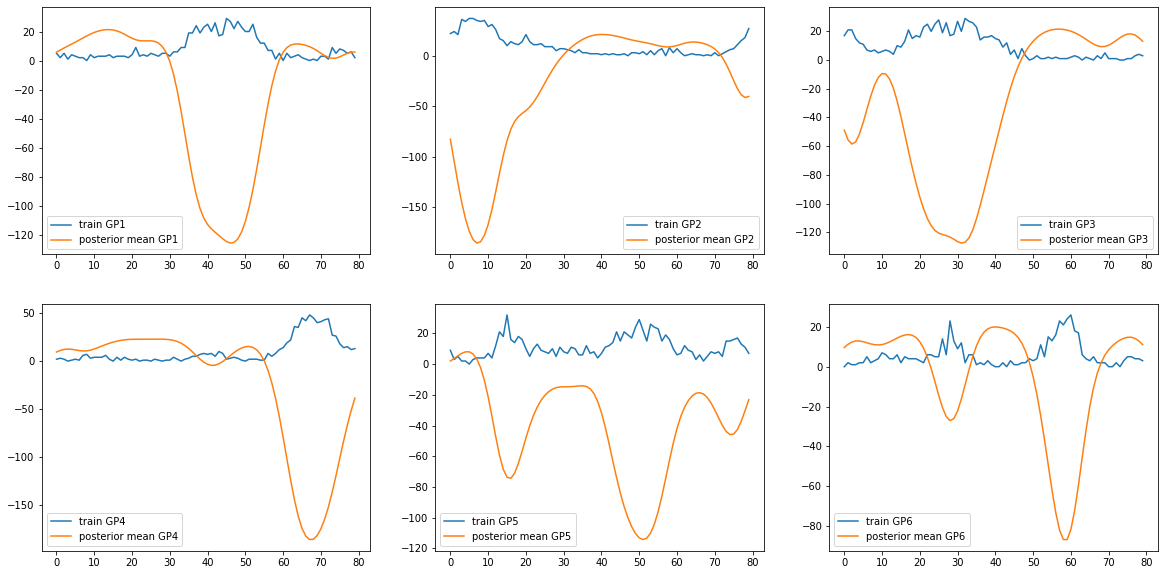

In [19]:
######################
#
# Your code goes here 
fig, ax = plt.subplots(2, 3, figsize=(20,10))

for idx, (P, M) in enumerate(nat_params):
    m, S = evaluate(P, M, timesteps)
    ax[idx//3, idx%3].plot(timesteps, train_data[:,idx], label=f'train GP{idx+1}')
    ax[idx//3, idx%3].plot(timesteps, m, label=f'posterior mean GP{idx+1}')
    ax[idx//3, idx%3].legend()
plt.show()
######################

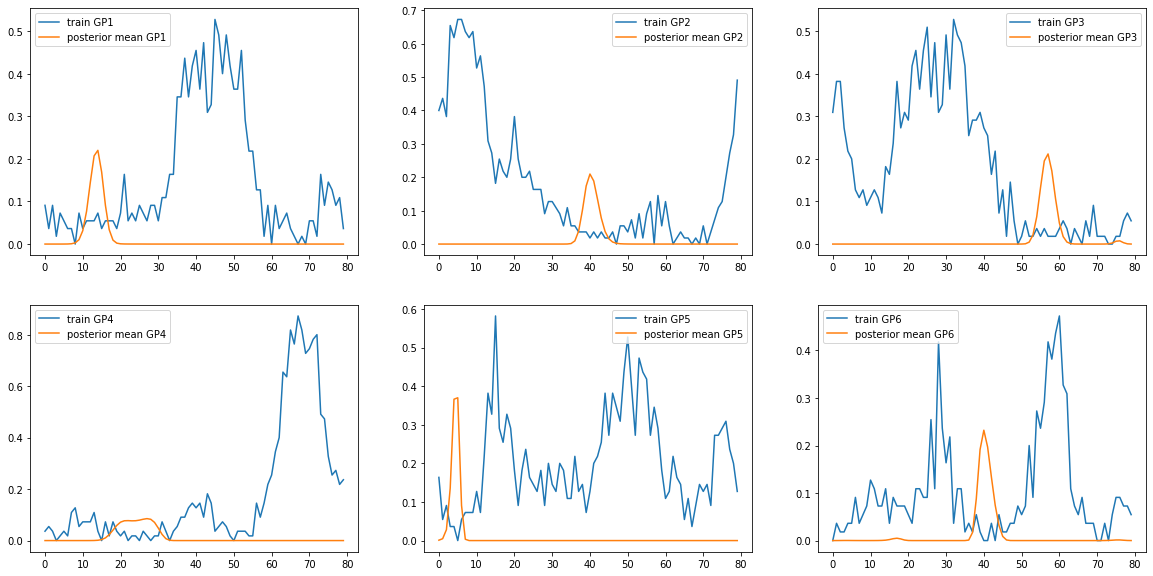

In [20]:
######################
#
fig, ax = plt.subplots(2, 3, figsize=(20,10))
data_norm = data / np.expand_dims(data.sum(axis=-1), axis=-1)

for idx, (P, M) in enumerate(nat_params):
    m, S = evaluate(P, M, timesteps)
    ax[idx//3, idx%3].plot(timesteps, data_norm[:80,idx], label=f'train GP{idx+1}')
    ax[idx//3, idx%3].plot(timesteps, softmax(m), label=f'posterior mean GP{idx+1}')
    ax[idx//3, idx%3].legend()
plt.show()
######################

### Test set

**Task:** Compute this point estimate for the test set and compare it to the actual training inputs, by e.g. visualising the results.

How good is the prediction?

<font color="blue">The prediction is not very good since the posterior mean is too "smooth" when compared to the test data and it doesn't capture the peaks.</font>

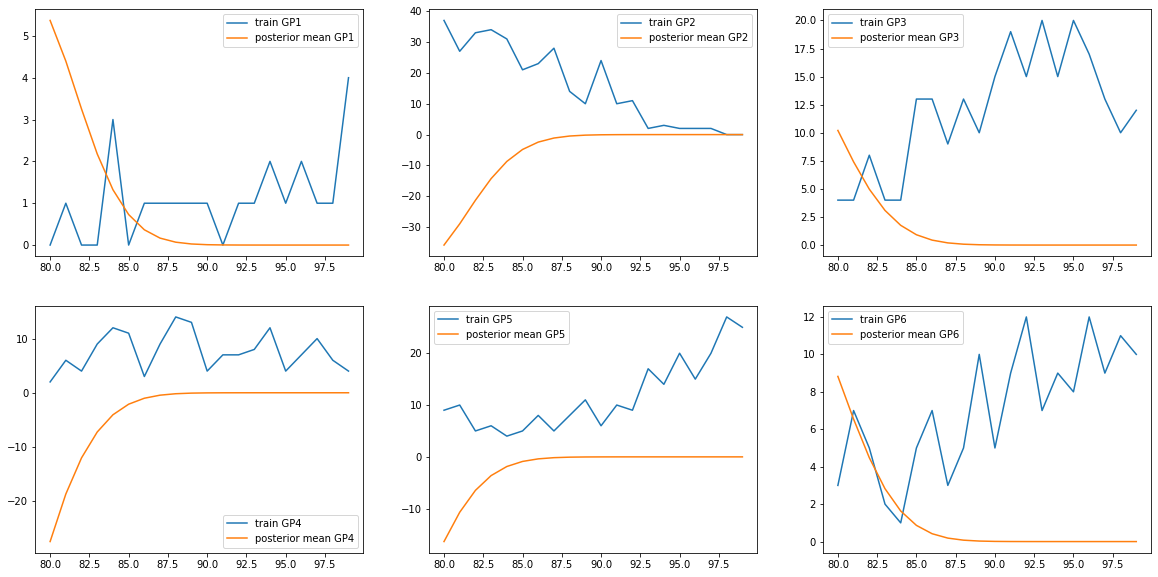

In [21]:
######################
ts = np.arange(test_data.shape[0]) + 80
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for idx, (P, M) in enumerate(nat_params):
    m, S = evaluate(P, M, ts)
    ax[idx//3, idx%3].plot(ts, test_data[:,idx], label=f'train GP{idx+1}')
    ax[idx//3, idx%3].plot(ts, m, label=f'posterior mean GP{idx+1}')
    ax[idx//3, idx%3].legend()
plt.show()
######################

## Summary

We learned how to carry out time series analysis with categorical data by enhancing using a probabilistic graphical model with Gaussian processes (i.e. features).
To do so, we needed to smoothly translate between Dirichlets and Gaussians which is possible with the Laplace bridge. 
Once the categorical data is translated into a Gaussian likelihood, standard Gaussian process regression is applicable. Resulting point estimates can be translated back into Dirichlets using the softmax.